# Classification model for resignation/dismissal:

Once we clean the dataset, we proceed to evaluate different models to calculate the probability that an agent leaves or would be dismissed from the company. To do this, we evaluate:

1. A logistic regression model
2. A decision tree model
3. A random forest model
4. A neural network model

Once we compute the probabilities for each model we compare the performance between them by using the ROC's area under the curve (AUC) criteria, since our problem is a classification one.

We begin by loading the packages and the clean dataset:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api         as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve, auc

plt.style.use('seaborn')

In [2]:
pd.set_option('display.max_columns', None)
datos_rf = pd.read_csv('C:/Users/ssego/Documents/Correlation One/Project/Data/DatasetClean.csv', encoding="utf-8", sep=',',
                       parse_dates=['Fecha_retiro', 'Fecha_Ingreso_Operacion'],
                       dtype = { # indicate categorical variables
                           'LineaNegocio': 'category',
                           'EstadoCivil': 'category',
                           'Genero': 'category',
                           'Hijos': 'category',
                           'CantidadHijos': 'category',
                           'Estrato': 'category',
                           'TipoVivienda': 'category',
                           'NivelAcademico': 'category',          
                           'TiempoExperiencia_s':'category',
                           'TiempoTrayecto':'category'
                       }
                      )

In [3]:
datos_rf[datos_rf['filter']==1].head(2)

,IdFuncionario,Cargo_Generico,Vr_Comision,Meta_Recaudo,Recaudo_Total,Cumpl_Individual,Cosecha_Liquidacion_x,Cosecha_Ingreso_Operacion,Fecha_Ingreso_Operacion,Fecha_retiro,LineaNegocio,Canal,Segmento,Dias_Asistencia,Dias_habiles_Mes,Ausentismo,TiempoConectado,TiempoProductivo,TiempoUtil,EstadoCivil,RH,Genero,Hijos,CantidadHijos,Localidad,Estrato,TipoVivienda,NivelAcademico,Estado,ExperienciaLab,TiempoExperiencia,TiempoExperiencia_s,Vr_Aspiracion,Perfil,TiempoTrayecto,MedioTransporte,PresentacionPersonal,Puntualidad,ExpresionVerbal,Apto,Apertura,Dialogo,Negociaciones,Cierre,Result_JuegoR,ClnNomCalf,ClnAsptCalf,ClnMejorarCalf,Result_Escucha,Result_Pond_Entrevista,Result_Pond_JuegoR,Result_Pond_Escucha,Result_total_Assess,Fortaliza1,Fortaliza2,Fortaliza3,Reconedacion1,Reconedacion2,Reconedacion3,Calificacion_Favorable,FuenteDatos,FechaNacimiento,UCN,UCP,Temporada,min_Fe_Ingreso,Fecha_Liq,Antiguedad_Meses,Fe_Retiro_Real,Retirado,max_Fe_Retiro,Retiro_3m,Retiro_6m,TiempoTrayecto_N,filter
34,988.0,Asesor,469973.125,45600000.0,33247837.69,72.911925,201812.0,201812.0,2018-12-03,NaT,Servicing,Bancolombia,Top,16.0,20.0,0.8,152.221029,122.644393,0.805699,Divorciado,NaN,Femenino,NO,0.0,Fontibón,NaN,Alquilada,Tecnólogo,Culminado,SI,ND,Más de 36 Meses,"$1,0 a $1,5",Completo,30 Min,A Pie,3.0,SI,4.0,SI,8.0,20.0,43.2,8.0,79.2,34.0,33.0,33.0,100.0,12.0,39.6,30.0,81.6,Capacidad de Escucha,Actitud,Comunicación Asertiva,Negociación,Discurso y Diálogo,NaN,Favorable,Informacion Access,29/05/1986,NaN,NaN,1.0,2018-12-03,2018-12-01,1,NaN,0,NaN,0,0,30 Min,1
35,988.0,Asesor,349700.625,57000000.0,38796999.93,68.064912,201901.0,201812.0,2018-12-03,NaT,Servicing,Bancolombia,Top,18.0,20.0,0.9,174.470738,138.679386,0.794858,Divorciado,NaN,Femenino,NO,0.0,Fontibón,NaN,Alquilada,Tecnólogo,Culminado,SI,ND,Más de 36 Meses,"$1,0 a $1,5",Completo,30 Min,A Pie,3.0,SI,4.0,SI,8.0,20.0,43.2,8.0,79.2,34.0,33.0,33.0,100.0,12.0,39.6,30.0,81.6,Capacidad de Escucha,Actitud,Comunicación Asertiva,Negociación,Discurso y Diálogo,NaN,Favorable,Informacion Access,29/05/1986,0.0,54.0,2.0,2018-12-01,2019-01-01,2,NaN,0,NaN,0,0,30 Min,1


In [4]:
datos_rf['Edad_Meses']        = (pd.to_datetime(datos_rf['Fecha_Liq']).dt.to_period('M').astype(int) - pd.to_datetime(datos_rf['FechaNacimiento']).dt.to_period('M').astype(int))
datos_rf['Edad_Anos']         = datos_rf['Edad_Meses'].apply(lambda x:int(x/12))
datos_rf['CantidadHijos']     = datos_rf['CantidadHijos'].replace(['-1.0'],['0.0'])
datos_rf['TiempoExperiencia'] = datos_rf['TiempoExperiencia'].replace(['ND'],[0])
datos_rf['TiempoExperiencia'] = datos_rf['TiempoExperiencia'].astype(str).astype(float)

In [5]:
datos_rf['dummy_goal'] = 0
datos_rf.loc[datos_rf[datos_rf['Cumpl_Individual']<=0.1].index,'dummy_goal'] = 1

In [6]:
datos_rf = datos_rf[(~datos_rf['Cumpl_Individual'].isnull()) & (datos_rf['Edad_Anos']>=18)]

In [7]:
datos_rf_filter = datos_rf[(datos_rf['filter']==1)]

### I. Logistic regression model:

Like explained on the EDA section, the company send us two different kinds of datasets. The first one has roughly 3.000 registers (`datos_rf_filter`), whilst the second has nearly 10.000 registers (`datos_rf`). However, despite the numerous observations of the latter dataset, this one only has performance variables (*e.g.* how much the agents are expected to recover during a certain month, how was this goal fulfilled, among others). The 3.000 observations dataset has valuable sociodemographic information such as the gender, where does the agent lives, among others.

Given the lack of information of the bigger dataset, we first proceed to run the regression with `datos_rf_filter` dataset. Our dependent variable would be `Retiro_3m`, which identifies an agent dismissal/resignation 3 months ahead on when it actually left the company.

The **first** model would evaluate a lot of variables, from which we are going to select the statistically significant latter on:

In [8]:
logit_model_all = smf.logit(formula='Retiro_3m ~ Vr_Comision + Cumpl_Individual + LineaNegocio + TiempoUtil + EstadoCivil + Genero + CantidadHijos + TipoVivienda + NivelAcademico + TiempoExperiencia + Antiguedad_Meses + Edad_Anos',data=datos_rf_filter).fit()
logit_model_all.summary()

Optimization terminated successfully.
         Current function value: 0.383884
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Retiro_3m   No. Observations:                 3250
Model:                          Logit   Df Residuals:                     3226
Method:                           MLE   Df Model:                           23
Date:                Tue, 24 Aug 2021   Pseudo R-squ.:                  0.1959
Time:                        17:17:56   Log-Likelihood:                -1247.6
converged:                       True   LL-Null:                       -1551.6
Covariance Type:            nonrobust   LLR p-value:                1.019e-113
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   1.3349      0.484      2.759      0.006       0.386       2.283
LineaNegocio[T.Npls]                       -0.0479      0.242     -0.198      0.843      -0.522       0.426
LineaNegocio[T.Servicing]                  -0.2072      0.241     -0.860      0.390      -0.679       0.265
EstadoCivil[T.Divorciado]                   0.1102      0.489      0.225      0.822      -0.849       1.069
EstadoCivil[T.Soltero]                     -0.1948      0.216     -0.902      0.367      -0.618       0.229
EstadoCivil[T.Unión Libre]                 -0.2024      0.225     -0.899      0.369      -0.644       0.239
EstadoCivil[T.Viudo]                        3.1706      1.138      2.785      0.005       0.939       5.402
Genero[T.Masculino]                         0.2578      0.118      2.194      0.028       0.028       0.488
CantidadHijos[T.1.0]                        0.1382      0.135      1.025      0.305      -0.126       0.402
CantidadHijos[T.2.0]                        0.3709      0.190      1.952      0.051      -0.002       0.743
CantidadHijos[T.3.0]                       -0.2119      0.327     -0.649      0.517      -0.852       0.428
CantidadHijos[T.4.0]                        1.1837      0.784      1.511      0.131      -0.352       2.720
TipoVivienda[T.Familiar]                    0.1881      0.118      1.591      0.112      -0.044       0.420
TipoVivienda[T.Propia]                      0.2684      0.180      1.495      0.135      -0.084       0.620
NivelAcademico[T.Profesional]              -0.1242      0.141     -0.880      0.379      -0.401       0.152
NivelAcademico[T.Sin Estudios Formales]    -0.0115      0.881     -0.013      0.990      -1.738       1.715
NivelAcademico[T.Tecnólogo]                -0.4362      0.168     -2.592      0.010      -0.766      -0.106
NivelAcademico[T.Técnico]                  -0.2298      0.132     -1.736      0.083      -0.489       0.030
Vr_Comision                             -1.036e-07   2.81e-07     -0.369      0.712   -6.55e-07    4.47e-07
Cumpl_Individual                           -0.0326      0.003    -12.836      0.000      -0.038      -0.028
TiempoUtil                                  0.0046      0.306      0.015      0.988      -0.595       0.605
TiempoExperiencia                           0.0245      0.019      1.303      0.193      -0.012       0.061
Antiguedad_Meses                           -0.0323      0.008     -3.813      0.000      -0.049      -0.016
Edad_Anos                                  -0.0261      0.011     -2.335      0.020      -0.048      -0.004
===========================================================================================================
"""

We could get some interesting insights from this particular model. First of all, it appears that most of the variables are not statistically significant. On the contrary, it seems that the variables related to goal fulfillment (`Cumpl_Individual`), seniority (`Antiguedad_Meses`), age (`Edad_Anos`) and gender (`Genero`) explain to some extent the decision to leave the company.

Given this results, we could run a **second** model just considering this factors:

In [9]:
logit_model_sig = smf.logit(formula='Retiro_3m ~ Cumpl_Individual + Genero + Antiguedad_Meses + Edad_Anos',data=datos_rf_filter).fit()
logit_model_sig.summary()

Optimization terminated successfully.
         Current function value: 0.390218
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Retiro_3m   No. Observations:                 3250
Model:                          Logit   Df Residuals:                     3245
Method:                           MLE   Df Model:                            4
Date:                Tue, 24 Aug 2021   Pseudo R-squ.:                  0.1826
Time:                        17:17:57   Log-Likelihood:                -1268.2
converged:                       True   LL-Null:                       -1551.6
Covariance Type:            nonrobust   LLR p-value:                2.476e-121
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6268      0.259      2.421      0.015       0.119       1.134
Genero[T.Masculino]     0.2558      0.104      2.452      0.014       0.051       0.460
Cumpl_Individual       -0.0325      0.002    -18.001      0.000      -0.036      -0.029
Antiguedad_Meses       -0.0376      0.008     -4.455      0.000      -0.054      -0.021
Edad_Anos              -0.0079      0.009     -0.932      0.351      -0.025       0.009
=======================================================================================
"""

As we could see, almost all the variables are statistically significant, except for `Edad_Anos`. To explore a litlle further why this could happen we plot the distribution of the variable between classes, finding that there is no apparent difference between both groups:

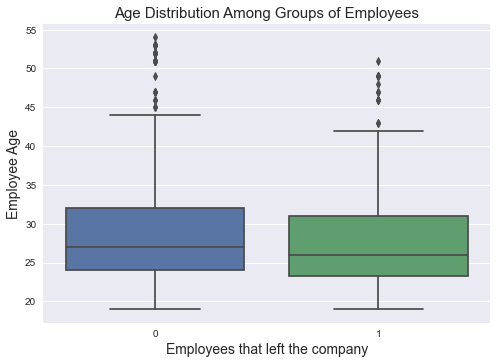

In [10]:
sns.boxplot(x = 'Retiro_3m', y = 'Edad_Anos', data = datos_rf_filter)
plt.xlabel("Employees that left the company", size=14)
plt.ylabel("Employee Age", size=14)
plt.title("Age Distribution Among Groups of Employees",size=15);

The analysis conducted on the EDA section validate some of the results found in the model. However, there is one that could be explored a little bit further by capturing some non-linearities in the model. In particular, the histograms of `Cumpl_Individual` showed that there could be a level from which we could differentiate the behaviour from dismissed employees and the others:

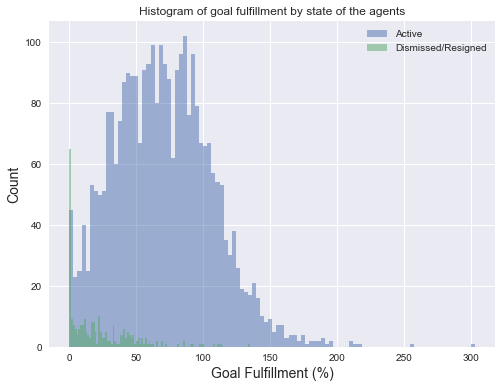

In [11]:
plt.figure(figsize=(8,6))
plt.hist(datos_rf_filter[(datos_rf_filter['Retirado']==0)].Cumpl_Individual, bins=100, alpha=0.5, label="Active")
plt.hist(datos_rf_filter[(datos_rf_filter['Retirado']==1)].Cumpl_Individual, bins=100, alpha=0.5, label="Dismissed/Resigned")

plt.xlabel("Goal Fulfillment (%)", size=14)
plt.ylabel("Count", size=14)
plt.title("Histogram of goal fulfillment by state of the agents")
plt.legend(loc='upper right');

For instance, we could explore in a **third** model if an employee with a goal fulfillment less than 10% a month has a greater probability of dismissal/resignation:

In [12]:
logit_model_dum = smf.logit(formula='Retiro_3m ~ Cumpl_Individual + dummy_goal + Genero + Antiguedad_Meses',data=datos_rf_filter).fit()
logit_model_dum.summary()

Optimization terminated successfully.
         Current function value: 0.389790
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Retiro_3m   No. Observations:                 3250
Model:                          Logit   Df Residuals:                     3245
Method:                           MLE   Df Model:                            4
Date:                Tue, 24 Aug 2021   Pseudo R-squ.:                  0.1835
Time:                        17:17:57   Log-Likelihood:                -1266.8
converged:                       True   LL-Null:                       -1551.6
Covariance Type:            nonrobust   LLR p-value:                6.181e-122
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.3283      0.112      2.933      0.003       0.109       0.548
Genero[T.Masculino]     0.2652      0.104      2.539      0.011       0.060       0.470
Cumpl_Individual       -0.0312      0.002    -16.222      0.000      -0.035      -0.027
dummy_goal              0.4629      0.246      1.885      0.059      -0.018       0.944
Antiguedad_Meses       -0.0391      0.008     -4.636      0.000      -0.056      -0.023
=======================================================================================
"""

Given the model, we could say that, on average, being a man increases the odds of leaving the company. Furthermore, greater levels of goal fulfillment and more seniority diminish the odds of leaving the company, although achieving a goal less than 10% greatly increases the odds of leaving the company. It is also interesting to note that some of these relationships were expected given the EDA conducted before, and we could also exploit even more this analysis by capturing some non-linearities.

When we compare the AIC criteria from the differente models we could see that this one exhibits the best behaviour:

|Model|AIC|Pseudo R-squared|
|---|---|---|
|All variables|2568.96|0.1930|
|Only significant|2566.17|0.1818|
|Goal fulfillment dummy|2564.65|0.1829|

Given that most of the statistically significant variables are available in the non-filtered dataset (`datos_rf`), we also fit the model using this dataset and comparing its AIC with the others:

In [13]:
logit_model_whole_df = smf.logit(formula='Retiro_3m ~ Cumpl_Individual + Antiguedad_Meses + Edad_Anos',data=datos_rf).fit()
logit_model_whole_df.summary()

Optimization terminated successfully.
         Current function value: 0.299181
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Retiro_3m   No. Observations:                 9678
Model:                          Logit   Df Residuals:                     9674
Method:                           MLE   Df Model:                            3
Date:                Tue, 24 Aug 2021   Pseudo R-squ.:                  0.2060
Time:                        17:17:57   Log-Likelihood:                -2895.5
converged:                       True   LL-Null:                       -3646.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0105      0.172      5.888      0.000       0.674       1.347
Cumpl_Individual    -0.0305      0.001    -27.218      0.000      -0.033      -0.028
Antiguedad_Meses    -0.0278      0.002    -11.627      0.000      -0.033      -0.023
Edad_Anos           -0.0217      0.006     -3.739      0.000      -0.033      -0.010
====================================================================================
"""

In [14]:
logit_model_whole_df.aic

5798.946081213758

As it turns out, this model performs badly compared with the filtered one in terms of AIC criteria. To determine another useful criteria of comparison we retrieve the predicted values of both models (filtered and whole dataset) to assess their performance using the ROC's area under the curve:

In [15]:
#filtered df:
f_logit_predict = logit_model_dum.predict()
f_roc_logit     = roc_curve(datos_rf_filter['Retiro_3m'],f_logit_predict)
f_auc_logit     = auc(f_roc_logit[0],f_roc_logit[1])

#whole df:
w_logit_predict = logit_model_whole_df.predict()
w_roc_logit_all = roc_curve(datos_rf['Retiro_3m'],w_logit_predict)
w_auc_logit_all = auc(w_roc_logit_all[0],w_roc_logit_all[1])

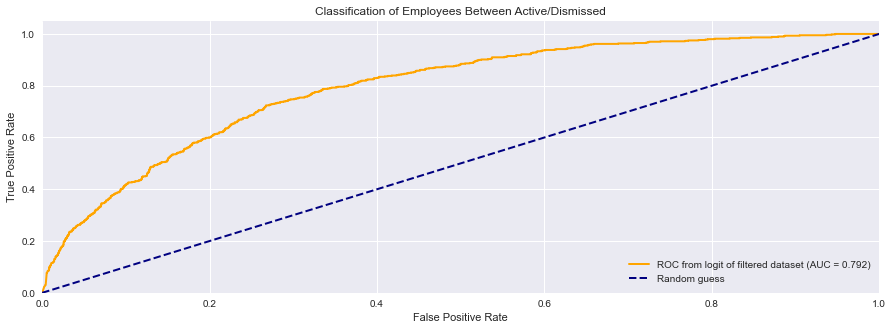

In [16]:
plt.figure(figsize=(15,5))
line_width = 2
plt.plot(f_roc_logit[0], f_roc_logit[1], color='orange', lw=line_width,
         label=f"ROC from logit of filtered dataset (AUC = {f_auc_logit:0.3f})")
# plt.plot(w_roc_logit_all[0], w_roc_logit_all[1], color='red', lw=line_width,
#          label=f"ROC from logit of whole dataset (AUC = {w_auc_logit_all:0.3f})")

plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Employees Between Active/Dismissed')
plt.legend(loc='lower right');

In [17]:
#https://realpython.com/logistic-regression-python/#beyond-logistic-regression-in-python

In [18]:
datos_rf_filter.columns

Index(['IdFuncionario', 'Cargo_Generico', 'Vr_Comision', 'Meta_Recaudo',
       'Recaudo_Total', 'Cumpl_Individual', 'Cosecha_Liquidacion_x',
       'Cosecha_Ingreso_Operacion', 'Fecha_Ingreso_Operacion', 'Fecha_retiro',
       'LineaNegocio', 'Canal', 'Segmento', 'Dias_Asistencia',
       'Dias_habiles_Mes', 'Ausentismo', 'TiempoConectado', 'TiempoProductivo',
       'TiempoUtil', 'EstadoCivil', 'RH', 'Genero', 'Hijos', 'CantidadHijos',
       'Localidad', 'Estrato', 'TipoVivienda', 'NivelAcademico', 'Estado',
       'ExperienciaLab', 'TiempoExperiencia', 'TiempoExperiencia_s',
       'Vr_Aspiracion', 'Perfil', 'TiempoTrayecto', 'MedioTransporte',
       'PresentacionPersonal', 'Puntualidad', 'ExpresionVerbal', 'Apto',
       'Apertura', 'Dialogo', 'Negociaciones', 'Cierre', 'Result_JuegoR',
       'ClnNomCalf', 'ClnAsptCalf', 'ClnMejorarCalf', 'Result_Escucha',
       'Result_Pond_Entrevista', 'Result_Pond_JuegoR', 'Result_Pond_Escucha',
       'Result_total_Assess', 'Fortaliza1', 'F

In [19]:
datos_rf_filter['label_ret'] = np.where(datos_rf_filter['Retirado']==0,'Active','Dismissed')

<ipython-input-19-bcff299bf37d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_rf_filter['label_ret'] = np.where(datos_rf_filter['Retirado']==0,'Active','Dismissed')


Text(0, 0.5, 'Employee Tenure')

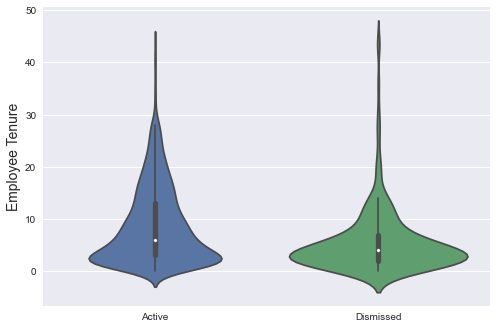

In [20]:
sns.violinplot(x = 'label_ret', y = 'Antiguedad_Meses', data = datos_rf_filter[datos_rf_filter['Antiguedad_Meses']>=0])
plt.xlabel("")
plt.ylabel("Employee Tenure", size=14)